## Image Colorization using GAN

*Overview*: This project provides an implementation of Image colorization using GANs (Generative Adversarial Networks), specifically using a U-Net architecture 
for the generator and a PatchCNN for the discriminator. The project is constructed in Python with [PyTorch](https://pytorch.org/docs/stable/index.html) as the deep learning framework, and 
[PyTorch-Candle](https://github.com/paraglondhe098/pytorch-candle) for efficient training process.

### Models used
This project comprises of two main models, namely a generator and a discriminator model.
1. `Unet Generator`: The generator model used is a U-Net model. This model is particularly effective for image-to-image translation problems.
2. `PatchDiscriminator`: The discriminator is implementing a PatchGAN style, which operates over patches of the image, rather than the whole image. It helps to make the model faster and more efficient.

In [ ]:
import os
experiment_name = "experiment_2"
result_folder = f"results/{experiment_name}"
data_folder = r"data/images"
num_images = 20000
os.makedirs(result_folder, exist_ok=True)

#### Install `pytorch-candle` a framework to train deep learning models (only pytorch-based)

In [ ]:
# !pip install --quiet --upgrade pytorch-candle

In [ ]:
import glob
import numpy as np
import torch
print(torch.__version__)

#### Note: For better performance, use GPU!

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
paths = glob.glob(data_folder + "/*.jpg")
len(paths)

40670

In [8]:
def get_img_paths(fpath,max_val,val_ratio):
  paths = np.random.choice(glob.glob(fpath),max_val,replace=False)
  val_paths = paths[:int(max_val*val_ratio)]
  train_paths = paths[int(max_val*val_ratio):]
  return train_paths,val_paths

In [12]:
train_paths,val_paths = get_img_paths(data_folder + "/*.jpg",num_images or 20000, 0.2)
len(train_paths), len(val_paths)

(16000, 4000)

In [13]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms as tt
import cv2
import numpy as np


class ImageTransformer:
    def __init__(self, normalization_value=0.5):
        self.normalize = tt.Compose([tt.ToTensor(),
                                     tt.Normalize((normalization_value, normalization_value, normalization_value),
                                                  (normalization_value, normalization_value, normalization_value))])
        self.denormalize = lambda x: x * normalization_value + normalization_value

    def transform(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        img = self.normalize(img)
        L = img[[0], ...]
        ab = img[[1, 2], ...]
        return L, ab

    def inverse_transform(self, L, ab, rtype="PIL"):
        img = torch.cat([L, ab], dim=0)
        img = self.denormalize(img)
        img = (img.permute(1, 2, 0) * 255).detach().cpu().numpy().astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
        if rtype == "PIL":
            return Image.fromarray(img)
        else:
            return img

    def inverse_transform_batch(self, L_batch, ab_batch, rtype="np"):
        Lab_batch = self.denormalize(torch.cat([L_batch, ab_batch], dim=1)) * 255
        Lab_batch = Lab_batch.permute(0, 2, 3, 1).detach().cpu().numpy().astype(np.uint8)
        rgb_imgs = []
        for img_lab in Lab_batch:
            img_rgb = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
            rgb_imgs.append(img_rgb if rtype == 'np' else Image.fromarray(img_rgb))
        return np.stack(rgb_imgs, axis=0) if rtype == 'np' else rgb_imgs


class ColorizationDataset(Dataset):
    def __init__(self, image_paths, split, size, preprocessor=None, return_original=False, rtype_original="PIL"):
        self.paths = image_paths
        self.transform = tt.Compose([
            tt.Resize((size, size), Image.BICUBIC),
            tt.RandomHorizontalFlip()
        ]) if split == "train" else tt.Resize((size, size), Image.BICUBIC)
        self.preprocessor = preprocessor or ImageTransformer()
        self.size = size
        self.return_original = return_original
        self.rtype_original = rtype_original

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = np.array(self.transform(img))
        L, ab = self.preprocessor.transform(img)
        if self.return_original:
            return L, ab, (Image.fromarray(img) if self.rtype_original == "PIL" else img)
        return L, ab

    def __len__(self):
        return len(self.paths)


In [14]:
trf = ImageTransformer()
train_ds = ColorizationDataset(train_paths, "train", size= 256, preprocessor=trf)
val_ds = ColorizationDataset(val_paths, "val", size= 256, preprocessor=trf)

Original Image


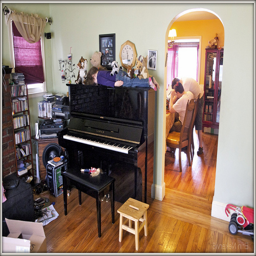

In [15]:
train_ds.return_original = True
img = train_ds[1][2]
train_ds.return_original = False
print("Original Image")
img

Transformed Image


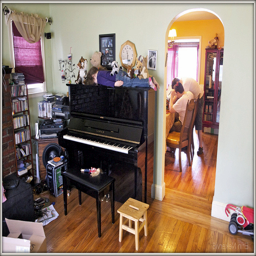

In [16]:
print("Transformed Image")
trf.inverse_transform(*train_ds[1])

In [17]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=16,pin_memory=True,shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16,pin_memory=True,shuffle=False)

In [18]:
data = next(iter(train_dl))
Ls, ab_s = data
print(Ls.shape, ab_s.shape)
print(len(train_dl),len(val_dl))

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
1000 250


In [19]:
import torch.nn as nn

class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)


class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)


class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down - 1) else 2)
                  for i in range(n_down)]  # the 'if' statement is taking care of not using
        # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False,
                                  act=False)]  # Make sure to not use normalization or
        # activation for the last layer of the model
        self.model = nn.Sequential(*model)

    @staticmethod
    def get_layers(ni, nf, k=4, s=2, p=1, norm=True,
                   act=True):  # when needing to make some repeatitive blocks of layers,
        layers = [
            nn.Conv2d(ni, nf, k, s, p, bias=not norm)]  # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class ImageColorizationModel(nn.Module):
    def __init__(self, generator,
                 discriminator,
                 weight_init_method="norm",
                 weight_init_gain=0.02 ):
        super().__init__()
        self.gen = self.init_weights(generator, weight_init_method, weight_init_gain)
        self.disc = self.init_weights(discriminator, weight_init_method, weight_init_gain)

    @staticmethod
    def init_weights(net, init='norm', gain=0.02):
        def init_func(m):
            classname = m.__class__.__name__
            if hasattr(m, 'weight') and 'Conv' in classname:
                if init == 'norm':
                    nn.init.normal_(m.weight.data, mean=0.0, std=gain)
                elif init == 'xavier':
                    nn.init.xavier_normal_(m.weight.data, gain=gain)
                elif init == 'kaiming':
                    nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias.data, 0.0)
            elif 'BatchNorm2d' in classname:
                nn.init.normal_(m.weight.data, 1., gain)
                nn.init.constant_(m.bias.data, 0.)

        net.apply(init_func)
        # print(f"model initialized with {init} initialization")
        return net


In [20]:
model = ImageColorizationModel(Unet(), PatchDiscriminator(input_c=3))

In [22]:
from candle.trainers.template import ModelConfig
from torch import optim
from torch.amp import  GradScaler

In [23]:
generator = ModelConfig(
    model = model.gen,
    name = "generator",
    optimizer = optim.Adam(model.gen.parameters(), lr=2e-4, betas=(0.5, 0.999)),
    scaler = GradScaler(enabled=torch.cuda.is_available())
)

In [24]:
discriminator = ModelConfig(
    model = model.disc,
    name = "discriminator",
    optimizer = optim.Adam(model.disc.parameters(), lr=2e-4, betas=(0.5, 0.999)),
    scaler = GradScaler(device = "cuda" if torch.cuda.is_available() else "cpu",enabled=torch.cuda.is_available())
)

In [25]:
from candle.callbacks import Callback, ConsoleLogger
import matplotlib.pyplot as plt


class ImageSaver(Callback):
    def __init__(self, L, real_ab, trnsformer, save_path, show=False):
        super().__init__()
        self.L = L
        self.real_ab = real_ab
        self.save_path = lambda idx: os.path.join(save_path, f"generated_{idx}.jpg")
        os.makedirs(save_path, exist_ok=True)
        self.trf = trnsformer
        self.show = show

    @torch.no_grad()
    def save_generated(self, current_epoch, L, real_ab, nmax = 4 ):
        L, real_ab = self.to_device(L), self.to_device(real_ab)
        save_path = self.save_path(current_epoch)
        fake_ab = self.model.gen(L)
        nmax = min(nmax, L.size(0))
        real_images = self.trf.inverse_transform_batch(L, real_ab, rtype="np")
        fake_images = self.trf.inverse_transform_batch(L, fake_ab, rtype="np")

        fig, axes = plt.subplots(3, nmax, figsize = (15, 8))
        fig.suptitle(f"Generated Images at Epoch {current_epoch}", fontsize = 16)

        for i in range(nmax):
            axes[0, i].imshow(L[i][0].cpu(), cmap='gray')
            axes[0, i].axis("off")
            if i == 0:
              axes[0, i].set_title("Input (L)")
            axes[1, i].imshow(fake_images[i])
            axes[1, i].axis("off")
            if i == 0:
              axes[1, i].set_title("Generated (Fake)")
            axes[2, i].imshow(real_images[i])
            axes[2, i].axis("off")
            if i == 0:
              axes[2, i].set_title("Real (AB)")
        fig.savefig(save_path, bbox_inches='tight')
        if self.show:
              plt.show()
        plt.close(fig)

    def on_epoch_end(self):
        self.save_generated(self.trainer.current_epoch, self.L, self.real_ab)


class CheckpointSaver(Callback):
    def __init__(self, save_path, save_interval):
        super().__init__()
        self.save_path = lambda epoch: os.path.join(save_path, f"epoch_{epoch}.pt")
        os.makedirs(save_path, exist_ok=True)
        self.save_interval = save_interval

    def on_epoch_end(self):
        if self.trainer.current_epoch % self.save_interval == 0:
            self.trainer.save_progress(self.save_path(self.trainer.current_epoch))



In [26]:
class GANLoss(nn.Module):
    def __init__(self, loss=nn.BCEWithLogitsLoss(), real_label=1.0, fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        self.loss = loss

    def __call__(self, preds, is_real):
        labels = self.real_label.expand_as(preds) if is_real else self.fake_label.expand_as(preds)
        return self.loss(preds, labels)


#### See the code of TrainerTemplate at: [template](https://github.com/paraglondhe098/pytorch-candle/blob/master/candle/trainers/template.py)

In [34]:
from candle.utils.tracking import Tracker
from candle.trainers.template import TrainerTemplate
from torch.amp import autocast
import torch.nn.functional as F


class ColorizationTrainer(TrainerTemplate):
    def __init__(self,
                 model,
                 generator_config,
                 discriminator_config,
                 callbacks,
                 gan_loss,
                 l1_lambda,
                 logger = None):
        super().__init__(model=model,
                         callbacks=callbacks,
                         clear_cuda_cache=True,
                         use_amp=True,
                         device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                         logger=logger)

        self.gen = generator_config
        self.disc = discriminator_config
        self.gan_loss = gan_loss
        self.l1_lambda = l1_lambda

    def init_tracker(self):
        return Tracker(["gen_loss", "disc_loss", "l1_loss", "val_loss"])

    def train_discriminator(self, L, real_ab):
        # self.disc.model.train()
        self.disc.set_requires_grad(True)
        L, real_ab = self.to_device(L), self.to_device(real_ab)

        self.disc.optimizer.zero_grad()
        with autocast(device_type=self.device.type, enabled=self.use_amp):
            real_images = torch.cat([L, real_ab], dim=1)
            real_predicted = self.disc.model(real_images)
            real_loss = self.gan_loss(real_predicted, is_real=True)

            with torch.no_grad():
                fake_ab = self.gen.model(L)
                fake_images = torch.cat([L, fake_ab], dim=1)
            fake_predicted = self.disc.model(fake_images.detach())
            fake_loss = self.gan_loss(fake_predicted, is_real=False)

            disc_loss = (real_loss + fake_loss) * 0.5

        self.disc.scaler.scale(disc_loss).backward()
        self.disc.scaler.step(self.disc.optimizer)
        self.disc.scaler.update()

        return disc_loss.item()

    def train_generator(self, L, real_ab):
        # self.gen.model.train()
        self.disc.set_requires_grad(False)

        self.gen.optimizer.zero_grad()
        with autocast(device_type=self.device.type, enabled=self.use_amp):
            fake_ab = self.gen.model(L)
            fake_images = torch.cat([L, fake_ab], dim=1)
            fake_predicted = self.disc.model(fake_images)
            gen_loss = self.gan_loss(fake_predicted, is_real=True)
            l1_loss = F.l1_loss(fake_ab, real_ab)
            total_loss = gen_loss + (self.l1_lambda * l1_loss)

        self.gen.scaler.scale(total_loss).backward()
        self.gen.scaler.step(self.gen.optimizer)
        self.gen.scaler.update()

        return gen_loss.item(), l1_loss.item()

    @torch.no_grad()
    def validate_generator(self, L, real_ab):
        # self.gen.model.eval()
        with autocast(device_type=self.device.type, enabled=self.use_amp):
            fake_ab = self.gen.model(L)
            val_loss = F.mse_loss(fake_ab.detach(), real_ab)
        return val_loss.item()

    def training_step(self, L, real_ab):
        disc_loss = self.train_discriminator(L, real_ab)
        gen_loss, l1_loss = self.train_generator(L, real_ab)
        self.tracker.update({"gen_loss": gen_loss, "disc_loss": disc_loss, "l1_loss": l1_loss})

    def eval_step(self, L, real_ab):
        val_loss = self.validate_generator(L, real_ab)
        self.tracker.update({"val_loss": val_loss})

    def prediction_step(self, L):
        fake_ab = self.gen.model(L)
        return torch.cat([L, fake_ab], dim=1)

    def save_progress(self, save_path):
        values = {
            "epoch": self.current_epoch,
            "gen": {
                "model": self.gen.model.state_dict(),
                "optimizer": self.gen.optimizer.state_dict(),
                "scaler": self.gen.scaler.state_dict()
            },
            "disc": {
                "model": self.disc.model.state_dict(),
                "optimizer": self.disc.optimizer.state_dict(),
                "scaler": self.disc.scaler.state_dict()
            },
            "tracker": self.tracker
        }
        torch.save(values, save_path)

    def load_progress(self, save_path):
        values = torch.load(save_path)
        self.gen.model.load_state_dict(values["gen"]["model"])
        self.gen.optimizer.load_state_dict(values["gen"]["optimizer"])
        self.gen.scaler.load_state_dict(values["gen"]["scaler"])

        self.disc.model.load_state_dict(values["disc"]["model"])
        self.disc.optimizer.load_state_dict(values["disc"]["optimizer"])
        self.disc.scaler.load_state_dict(values["disc"]["scaler"])

        self.tracker = values["tracker"]
        self._best_state_dict = self.gen.model.state_dict()
        self._final_metrics = self.tracker.get_final_values(self.current_epoch)
        self._current_epoch = self.tracker.current_epoch

    def reset_progress(self):
        self._current_epoch = 0
        self.STOPPER = False
        self._best_state_dict = None
        self._final_metrics = {}
        self.tracker = self.init_tracker()


In [38]:
# ## Since Logging isn't working on kaggle
# class PrintLogger:
#     def info(self, x):
#         print(x)
#     def warning(self, x):
#         print(x)
#     def debug(self, x):
#         print(x)

In [39]:
trainer = ColorizationTrainer(
    model = model,
    generator_config = generator,
    discriminator_config = discriminator,
    callbacks = [CheckpointSaver(result_folder + "/checkpoints", 10),
                 ConsoleLogger(progress_bar_positions=["training", "validation"]),
                 ImageSaver(*next(iter(val_dl)), trf, result_folder + "/generated_images", show=False)],
    gan_loss = GANLoss().to(device),
    l1_lambda = 100,
    # logger = PrintLogger()
)

In [40]:
history = trainer.fit(train_dl, val_dl, epochs=10)

---------------------------------------------Progress---------------------------------------------


Validation: 100%|██████████| 250/250 [00:44<00:00,  5.66it/s]


--> Metrics:   gen_loss: 1.2122 ,disc_loss: 0.5599 ,l1_loss: 0.0874 ,val_loss: 0.0247
Time elapsed: 356.71306896209717 s
----------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 250/250 [00:43<00:00,  5.70it/s]


--> Metrics:   gen_loss: 1.2232 ,disc_loss: 0.5603 ,l1_loss: 0.0869 ,val_loss: 0.0189
Time elapsed: 715.675523519516 s
----------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 250/250 [00:43<00:00,  5.74it/s]


--> Metrics:   gen_loss: 1.2427 ,disc_loss: 0.5551 ,l1_loss: 0.0864 ,val_loss: 0.0181
Time elapsed: 1072.5211536884308 s
----------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 250/250 [00:44<00:00,  5.68it/s]


--> Metrics:   gen_loss: 1.2549 ,disc_loss: 0.5494 ,l1_loss: 0.0860 ,val_loss: 0.0168
Time elapsed: 1429.527535200119 s
----------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 250/250 [00:43<00:00,  5.76it/s]


--> Metrics:   gen_loss: 1.2847 ,disc_loss: 0.5453 ,l1_loss: 0.0853 ,val_loss: 0.0163
Time elapsed: 1787.5137498378754 s
----------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 250/250 [00:43<00:00,  5.77it/s]


--> Metrics:   gen_loss: 1.2957 ,disc_loss: 0.5397 ,l1_loss: 0.0847 ,val_loss: 0.0167
Time elapsed: 2144.3484828472137 s
----------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 250/250 [00:44<00:00,  5.67it/s]


--> Metrics:   gen_loss: 1.3144 ,disc_loss: 0.5438 ,l1_loss: 0.0842 ,val_loss: 0.0197
Time elapsed: 2502.521781206131 s
----------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 250/250 [00:43<00:00,  5.69it/s]


--> Metrics:   gen_loss: 1.3155 ,disc_loss: 0.5442 ,l1_loss: 0.0836 ,val_loss: 0.0178
Time elapsed: 2863.405755996704 s
----------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 250/250 [00:43<00:00,  5.73it/s]


--> Metrics:   gen_loss: 1.3247 ,disc_loss: 0.5401 ,l1_loss: 0.0832 ,val_loss: 0.0162
Time elapsed: 3222.5574769973755 s
----------------------------------------------------------------------------------------------------


Validation: 100%|██████████| 250/250 [00:44<00:00,  5.65it/s]


--> Metrics:   gen_loss: 1.3340 ,disc_loss: 0.5385 ,l1_loss: 0.0820 ,val_loss: 0.0179
Time elapsed: 3581.1285927295685 s
----------------------------------------------------------------------------------------------------


{'gen_loss': [1.2122221637964248,
  1.2231859878599645,
  1.2427426206171512,
  1.254853572845459,
  1.2847117329239846,
  1.2956997114121913,
  1.3143509497344494,
  1.3155093630254269,
  1.3247070807516574,
  1.3339841971993447],
 'disc_loss': [0.5598817306905984,
  0.5602828947603703,
  0.5551413538977503,
  0.5494103051051498,
  0.5452843329459429,
  0.5397342880219221,
  0.5437846524864435,
  0.5442151721864938,
  0.5401495146006345,
  0.5384508919864893],
 'l1_loss': [0.08737502505630254,
  0.08687860867008566,
  0.08637762421369552,
  0.08604517682641745,
  0.08527283647283912,
  0.08466167491674423,
  0.0842451484426856,
  0.08364734814316034,
  0.08322333550080657,
  0.08201058268547058],
 'val_loss': [0.024745982564985752,
  0.018944037921726702,
  0.018074027199298143,
  0.016814509760588407,
  0.01629602811858058,
  0.016678437642753126,
  0.019667833991348742,
  0.01778656041994691,
  0.016162482567131518,
  0.017850047003477813]}

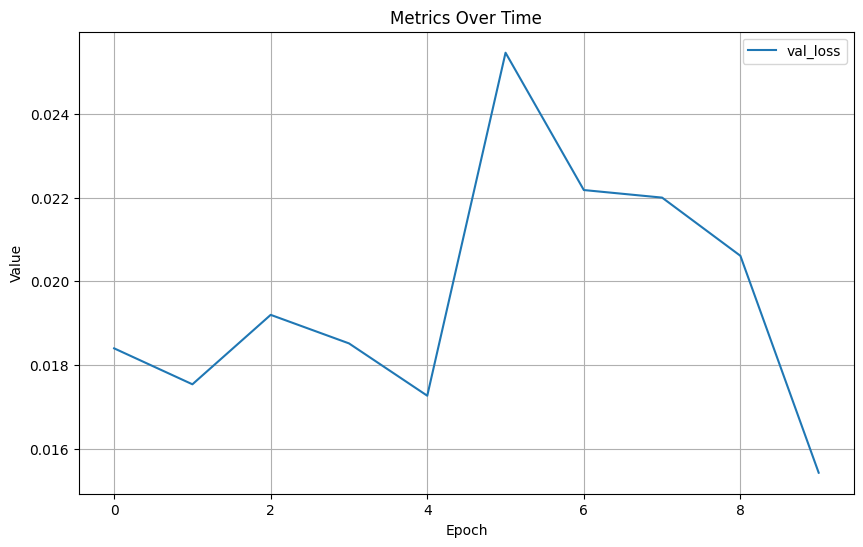

In [4]:
trainer.tracker.plot("val_loss")

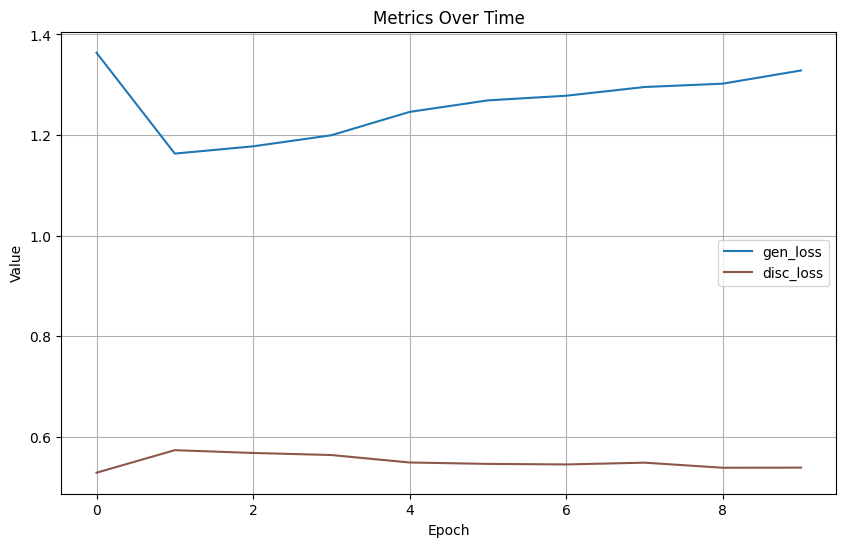

In [5]:
trainer.tracker.plot("gen_loss", "disc_loss")

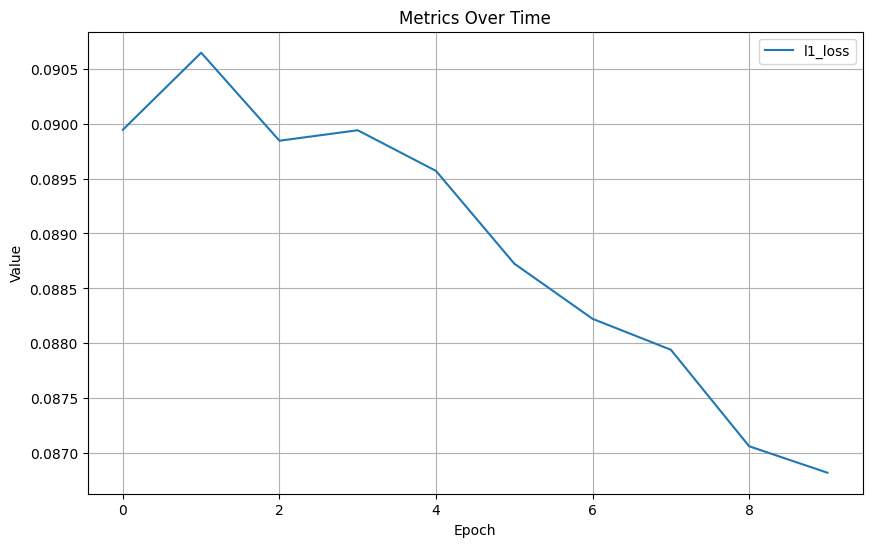

In [6]:
trainer.tracker.plot("l1_loss")

In [7]:
trainer.save_progress(result_folder + "/final.pt")

### Inspired from article: [Colorizing black & white images with U-Net and conditional GAN — A Tutorial](https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8)
by *Moein Shariatnia*

### Let's connect:
- [GitHub](https://github.com/paraglondhe098)
- [YouTube](https://www.youtube.com/@Neuralogic-j8i)
- [LinkedIn](https://github.com/paraglondhe098)

<div align="center">
___________________________________Thank You___________________________________</div>